In [5]:
%matplotlib inline

from yahooquery import Ticker

import datetime as dt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [21]:
ticker = Ticker("^GSPC")

df = ticker.history(start="1999-01-01", end="2020-01-01")

df

open          low      volume        close  \
symbol date                                                            
^GSPC  1999-01-04  1229.229980  1219.099976   877000000  1228.099976   
       1999-01-05  1228.099976  1228.099976   775000000  1244.780029   
       1999-01-06  1244.780029  1244.780029   986900000  1272.339966   
       1999-01-07  1272.339966  1257.680054   863000000  1269.729980   
       1999-01-08  1269.729980  1261.819946   937800000  1275.089966   
...                        ...          ...         ...          ...   
       2019-12-24  3225.449951  3220.510010  1296540000  3223.379883   
       2019-12-26  3227.199951  3227.199951  2160680000  3239.909912   
       2019-12-27  3247.229980  3234.370117  2428670000  3240.020020   
       2019-12-30  3240.090088  3216.570068  3013290000  3221.290039   
       2019-12-31  3215.179932  3212.030029  2893810000  3230.780029   

                          high     adjclose  
symbol date                                  
^GSPC  1999-01-04  1248.810059  1228.099976  
       1999-01-05  1246.109985  1244.780029  
       1999-01-06  1272.500000  1272.339966  
       1999-01-07  1272.339966  1269.729980  
       1999-01-08  1278.239990  1275.089966  
...                        ...          ...  
       2019-12-24  3226.429932  3223.379883  
       2019-12-26  3240.080078  3239.909912  
       2019-12-27  3247.929932  3240.020020  
       2019-12-30  3240.919922  3221.290039  
       2019-12-31  3231.719971  3230.780029  

[5283 rows x 6 columns]

In [22]:
df.reset_index().dtypes

symbol       object
date         object
open        float64
low         float64
volume        int64
close       float64
high        float64
adjclose    float64
dtype: object

In [23]:
df.describe()

,open,low,volume,close,high,adjclose
count,5283.000000,5283.000000,5.283000e+03,5283.000000,5283.000000,5283.000000
mean,1562.972945,1553.323175,2.982766e+09,1563.194925,1571.913684,1563.194925
std,574.270273,573.443163,1.518712e+09,574.357883,574.951299,574.357883
min,679.280029,666.789978,3.121200e+08,676.530029,695.270020,676.530029
25%,1163.534973,1154.779968,1.519050e+09,1163.349976,1172.744995,1163.349976
50%,1351.930054,1340.479980,3.140730e+09,1351.949951,1361.390015,1351.949951
75%,1949.854980,1939.009949,3.878100e+09,1950.974976,1962.154968,1950.974976
max,3247.229980,3234.370117,1.145623e+10,3240.020020,3247.929932,3240.020020


In [24]:
# Remove ticker from index and tranform date to Pandas datetime
df = df.loc[df.index.get_level_values(0)[0]]
df.index = pd.to_datetime(df.index)

df

,open,low,volume,close,high,adjclose
date,,,,,,
1999-01-04,1229.229980,1219.099976,877000000,1228.099976,1248.810059,1228.099976
1999-01-05,1228.099976,1228.099976,775000000,1244.780029,1246.109985,1244.780029
1999-01-06,1244.780029,1244.780029,986900000,1272.339966,1272.500000,1272.339966
1999-01-07,1272.339966,1257.680054,863000000,1269.729980,1272.339966,1269.729980
1999-01-08,1269.729980,1261.819946,937800000,1275.089966,1278.239990,1275.089966
...,...,...,...,...,...,...
2019-12-24,3225.449951,3220.510010,1296540000,3223.379883,3226.429932,3223.379883
2019-12-26,3227.199951,3227.199951,2160680000,3239.909912,3240.080078,3239.909912
2019-12-27,3247.229980,3234.370117,2428670000,3240.020020,3247.929932,3240.020020


In [25]:
# Check for NAs
df.isnull().values.any()

False

In [42]:
adjclose = df["adjclose"]

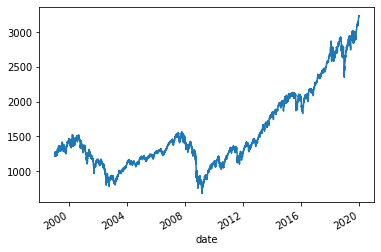

In [43]:
# Plot adjusted close
adjclose.plot();

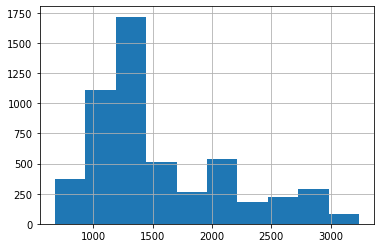

In [45]:
adjclose.hist();

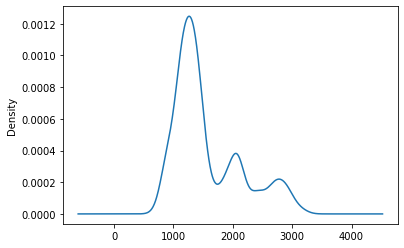

In [46]:
adjclose.plot.kde();

In [47]:
# Test for statitionarity
from statsmodels.tsa.stattools import adfuller

ADF_result = adfuller(adjclose)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistic: 1.49008703663717
p-value: 0.997487317047142


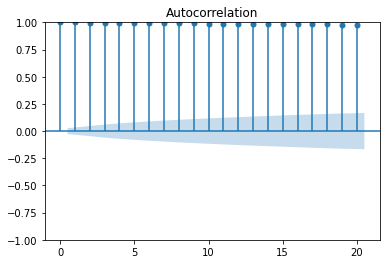

In [48]:
plot_acf(adjclose, lags=20);

In [51]:
diff_adjclose = np.diff(adjclose, n=1)

ADF_result = adfuller(diff_adjclose)

print(f"ADF Statistic: {ADF_result[0]}")
print(f"p-value: {ADF_result[1]}")

ADF Statistic: -17.415712262061714
p-value: 4.85753037466549e-30


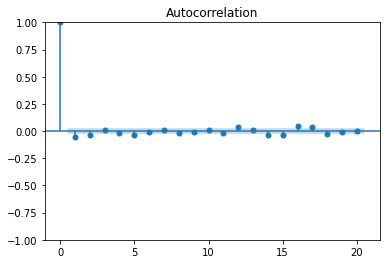

In [52]:
plot_acf(diff_adjclose, lags=20);

Voila, random walk

In [53]:
train_df, test_df = train_test_split(df[["adjclose"]], test_size=0.2, shuffle=False)
train_df, test_df

(               adjclose
 date                   
 1999-01-04  1228.099976
 1999-01-05  1244.780029
 1999-01-06  1272.339966
 1999-01-07  1269.729980
 1999-01-08  1275.089966
 ...                 ...
 2015-10-13  2003.689941
 2015-10-14  1994.239990
 2015-10-15  2023.859985
 2015-10-16  2033.109985
 2015-10-19  2033.660034
 
 [4226 rows x 1 columns],
                adjclose
 date                   
 2015-10-20  2030.770020
 2015-10-21  2018.939941
 2015-10-22  2052.510010
 2015-10-23  2075.149902
 2015-10-26  2071.179932
 ...                 ...
 2019-12-24  3223.379883
 2019-12-26  3239.909912
 2019-12-27  3240.020020
 2019-12-30  3221.290039
 2019-12-31  3230.780029
 
 [1057 rows x 1 columns])

In [54]:
train_s = train_df["adjclose"]
train_s

date
1999-01-04    1228.099976
1999-01-05    1244.780029
1999-01-06    1272.339966
1999-01-07    1269.729980
1999-01-08    1275.089966
                 ...     
2015-10-13    2003.689941
2015-10-14    1994.239990
2015-10-15    2023.859985
2015-10-16    2033.109985
2015-10-19    2033.660034
Name: adjclose, Length: 4226, dtype: float64

In [55]:
pred_df = test_df.copy()
pred_df

,adjclose
date,
2015-10-20,2030.770020
2015-10-21,2018.939941
2015-10-22,2052.510010
2015-10-23,2075.149902
2015-10-26,2071.179932
...,...
2019-12-24,3223.379883
2019-12-26,3239.909912
2019-12-27,3240.020020


In [56]:
pred_df["mean"] = train_s.mean()
pred_df

,adjclose,mean
date,,
2015-10-20,2030.770020,1322.041479
2015-10-21,2018.939941,1322.041479
2015-10-22,2052.510010,1322.041479
2015-10-23,2075.149902,1322.041479
2015-10-26,2071.179932,1322.041479
...,...,...
2019-12-24,3223.379883,1322.041479
2019-12-26,3239.909912,1322.041479
2019-12-27,3240.020020,1322.041479


In [57]:
pred_df["last_value"] = train_s.iloc[-1]
pred_df

,adjclose,mean,last_value
date,,,
2015-10-20,2030.770020,1322.041479,2033.660034
2015-10-21,2018.939941,1322.041479,2033.660034
2015-10-22,2052.510010,1322.041479,2033.660034
2015-10-23,2075.149902,1322.041479,2033.660034
2015-10-26,2071.179932,1322.041479,2033.660034
...,...,...,...
2019-12-24,3223.379883,1322.041479,2033.660034
2019-12-26,3239.909912,1322.041479,2033.660034
2019-12-27,3240.020020,1322.041479,2033.660034


In [58]:
delta_X = len(train_s)
delta_y = train_s.iloc[-1] - train_s.iloc[0]

drift = delta_y / delta_X
drift

0.19061998546941553

In [59]:
pred_df["drift"] = (
    drift * np.arange(len(train_s) + 1, len(train_s) + 1 + len(test_df))
    + train_s.iloc[0]
)
pred_df

,adjclose,mean,last_value,drift
date,,,,
2015-10-20,2030.770020,1322.041479,2033.660034,2033.850654
2015-10-21,2018.939941,1322.041479,2033.660034,2034.041274
2015-10-22,2052.510010,1322.041479,2033.660034,2034.231894
2015-10-23,2075.149902,1322.041479,2033.660034,2034.422514
2015-10-26,2071.179932,1322.041479,2033.660034,2034.613134
...,...,...,...,...
2019-12-24,3223.379883,1322.041479,2033.660034,2234.382879
2019-12-26,3239.909912,1322.041479,2033.660034,2234.573499
2019-12-27,3240.020020,1322.041479,2033.660034,2234.764119


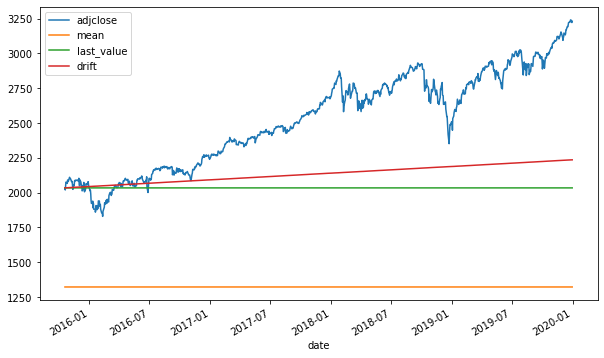

In [60]:
pred_df.plot(figsize=(10, 6));

In [61]:
pred_df["prev_value"] = pred_df["adjclose"].shift()
pred_df["prev_value"].iloc[[0]] = train_s.iloc[-1]
pred_df

,adjclose,mean,last_value,drift,prev_value
date,,,,,
2015-10-20,2030.770020,1322.041479,2033.660034,2033.850654,2033.660034
2015-10-21,2018.939941,1322.041479,2033.660034,2034.041274,2030.770020
2015-10-22,2052.510010,1322.041479,2033.660034,2034.231894,2018.939941
2015-10-23,2075.149902,1322.041479,2033.660034,2034.422514,2052.510010
2015-10-26,2071.179932,1322.041479,2033.660034,2034.613134,2075.149902
...,...,...,...,...,...
2019-12-24,3223.379883,1322.041479,2033.660034,2234.382879,3224.010010
2019-12-26,3239.909912,1322.041479,2033.660034,2234.573499,3223.379883
2019-12-27,3240.020020,1322.041479,2033.660034,2234.764119,3239.909912


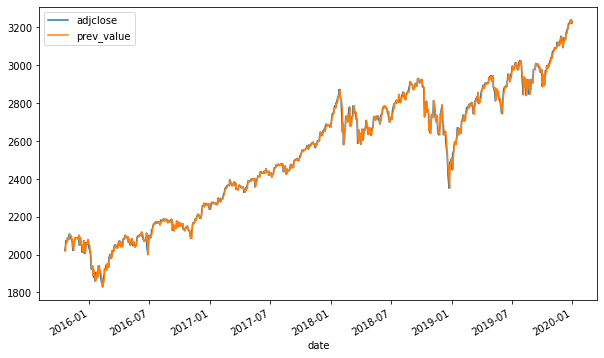

In [62]:
pred_df[["adjclose", "prev_value"]].plot(figsize=(10, 6));

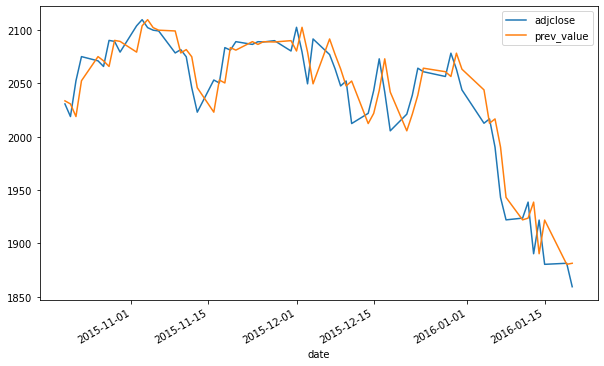

In [63]:
pred_df[["adjclose", "prev_value"]][:63].plot(figsize=(10, 6));

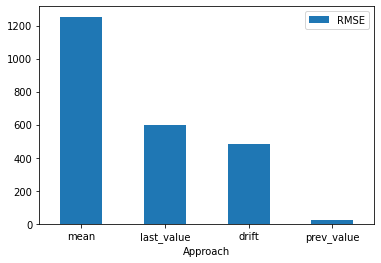

In [64]:
rmse_results = {
    "mean": mean_squared_error(pred_df["adjclose"], pred_df["mean"], squared=False),
    "last_value": mean_squared_error(
        pred_df["adjclose"], pred_df["last_value"], squared=False
    ),
    "drift": mean_squared_error(pred_df["adjclose"], pred_df["drift"], squared=False),
    "prev_value": mean_squared_error(
        pred_df["adjclose"], pred_df["prev_value"], squared=False
    ),
}

pd.DataFrame({"Approach": rmse_results.keys(), "RMSE": rmse_results.values()}).plot.bar(
    x="Approach", y="RMSE", rot=0
);

In [67]:
for name, value in rmse_results.items():
    print(f"{name:8s}\t{value:0.4f}")

mean    	1252.6407
last_value	600.0554
drift   	485.7396
prev_value	20.6400
